# CP8305 Project: MNIST Classification using SVM and CNN

## 1.0 Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from keras import layers
from keras import models

### Loading Functions

In [2]:
def counts_from_confusion(confusion):
    """
    Obtain TP, FN FP, and TN for each class in the confusion matrix
    """

    counts_list = []
    TP = []
    TN = []
    FP = []
    FN = []
    Supp = []
    Macro_avg_accuracy = []
    Macro_avg_sensitivity = []
    Macro_avg_specificity = []
    Micro_avg_accuracy = []
    Micro_avg_sensitivity = []
    Micro_avg_specificity = []
   
    # Iterate through classes and store the counts
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]

        fn_mask = np.zeros(confusion.shape)
        fn_mask[:, i] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion, fn_mask))

        fp_mask = np.zeros(confusion.shape)
        fp_mask[i, :] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion, tn_mask))

        counts_list.append({'Class': i,
                            'TP': tp,
                            'FN': fn,
                            'FP': fp,
                            'TN': tn,
                            'Accuracy': (tp + tn)/(tp + fp + tn + fn),
                            'Sensitivity': tp/(tp+fn),
                            'Specificity': tn/(tn+fp),
                            'Support': sum(confusion[i, :])})
        
        # Overall Performance
        TP.append(tp)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        Supp.append(sum(confusion[i, :]))
        Macro_avg_accuracy.append((tp + tn)/(tp + fp + tn + fn))
        Macro_avg_sensitivity.append(tp/(tp+fn))
        Macro_avg_specificity.append(tn/(tn+fp))

    ACC = sum(TP)/(sum(Supp))
    
    Macro_avg_accuracy = sum(Macro_avg_accuracy)/confusion.shape[0]
    Macro_avg_sensitivity = sum(Macro_avg_sensitivity)/confusion.shape[0]
    Macro_avg_specificity = sum(Macro_avg_specificity)/confusion.shape[0]

    Micro_avg_accuracy = (sum(TP)+sum(TN))/(sum(TP)+sum(TN)+sum(FP)+sum(FN))
    Micro_avg_sensitivity = (sum(TP))/(sum(TP)+sum(FN))
    Micro_avg_specificity = (sum(TN))/(sum(TN)+sum(FP))
    
    counts_list = pd.DataFrame.from_dict(counts_list)

    new = [{'Class': '', 'TP':'', 'FN':'', 'FP':'', 'TN':'', 'Accuracy':'', 'Sensitivity':'', 'Specificity':'', 'Support':''},
           {'Class': 'Accuracy', 'TP':'', 'FN':'', 'FP':'', 'TN':'', 'Accuracy': ACC, 'Sensitivity':'', 'Specificity':'', 'Support':sum(Supp)},
           {'Class': 'Macro Avg', 'TP':'', 'FN':'', 'FP':'', 'TN':'', 'Accuracy': Macro_avg_accuracy, 'Sensitivity':Macro_avg_sensitivity, 'Specificity':Macro_avg_specificity, 'Support':sum(Supp)},
           {'Class': 'Micro Avg', 'TP':'', 'FN':'', 'FP':'', 'TN':'', 'Accuracy': Micro_avg_accuracy, 'Sensitivity':Micro_avg_sensitivity, 'Specificity':Micro_avg_specificity, 'Support':sum(Supp)}]
    
    
    counts_list = counts_list.append(new, ignore_index=True)
        
    return counts_list



In [3]:
#Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [4]:
# Ref: https://github.com/DTrimarchi10/confusion_matrix
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

# %load C:\Users\mnbas\Documents\MASc Courses\CP8305 - Knowledge Discovery\Project\Code\confusion_matrix-master\confusion_matrix-master\cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## 2.0 Loading Dataset

In [5]:
(train_images_raw, train_labels_raw), (test_images_raw,test_labels_raw) = mnist.load_data()

### Printing Dataset Information

In [6]:
print('Number of images in training set: %d' % train_images_raw.shape[0])
print(train_labels_raw)
print()

print('Number of images in testing set: %d' % test_images_raw.shape[0])
print(test_labels_raw)
print()

print('Size of image: %d x %d pixels' % train_images_raw.shape[1:3])

Number of images in training set: 60000
[5 0 4 ... 5 6 8]

Number of images in testing set: 10000
[7 2 1 ... 4 5 6]

Size of image: 28 x 28 pixels


### Label Distribution

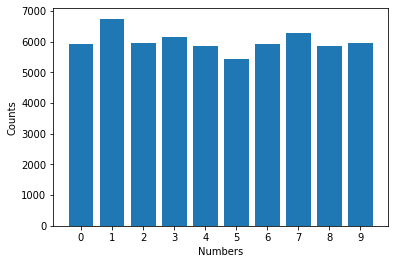

In [7]:
unique, counts = np.unique(train_labels_raw, return_counts=True)

plt.figure()
plt.bar(range(10), counts, tick_label=range(10))
plt.xlabel("Numbers")
plt.ylabel("Counts")
plt.show()

### Showing Sample Images

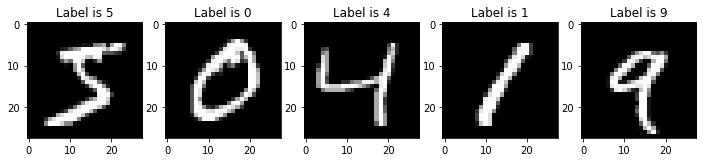

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(151)
plt.imshow(train_images_raw[0],cmap='gray')
plt.title('Label is {label}'.format(label=train_labels_raw[0]))
plt.subplot(152)
plt.imshow(train_images_raw[1],cmap='gray')
plt.title('Label is {label}'.format(label=train_labels_raw[1]))
plt.subplot(153)
plt.imshow(train_images_raw[2],cmap='gray')
plt.title('Label is {label}'.format(label=train_labels_raw[2]))
plt.subplot(154)
plt.imshow(train_images_raw[3],cmap='gray')
plt.title('Label is {label}'.format(label=train_labels_raw[3]))
plt.subplot(155)
plt.imshow(train_images_raw[4],cmap='gray')
plt.title('Label is {label}'.format(label=train_labels_raw[4]))
plt.show()

## 3.0 Classification

### 3.1 Support Vector Machines (SVM)

### 3.1.1 Pre-processing

#### Preparing Image Data

In [9]:
train_images = train_images_raw.reshape((train_images_raw.shape[0], train_images_raw.shape[1]*train_images_raw.shape[2]))
train_images = train_images.astype('float32')/255

test_images = test_images_raw.reshape((test_images_raw.shape[0], test_images_raw.shape[1]*test_images_raw.shape[2]))
test_images = test_images.astype('float32')/255


print('Original image data:')
print(train_images_raw[0])
print()
print('Pre-processed image data:')
print(train_images[0])

Original image data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 2

### 3.1.2 SVM Classification

# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished


Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.980 (+/-0.005) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



,Class,TP,FN,FP,TN,Accuracy,Sensitivity,Specificity,Support
0,0,973,18,7,9002,0.9975,0.981837,0.999223,980
1,1,1130,10,5,8855,0.9985,0.991228,0.999436,1135
2,2,1014,20,18,8948,0.9962,0.980658,0.997992,1032
3,3,994,20,16,8970,0.9964,0.980276,0.998219,1010
4,4,965,17,17,9001,0.9966,0.982688,0.998115,982
5,5,872,14,20,9094,0.9966,0.984199,0.997806,892
6,6,945,7,13,9035,0.998,0.992647,0.998563,958
7,7,1005,19,23,8953,0.9958,0.981445,0.997438,1028
8,8,953,16,21,9010,0.9963,0.983488,0.997675,974
9,9,982,26,27,8965,0.9947,0.974206,0.996997,1009


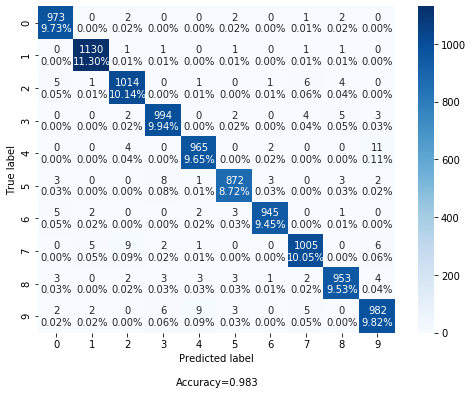

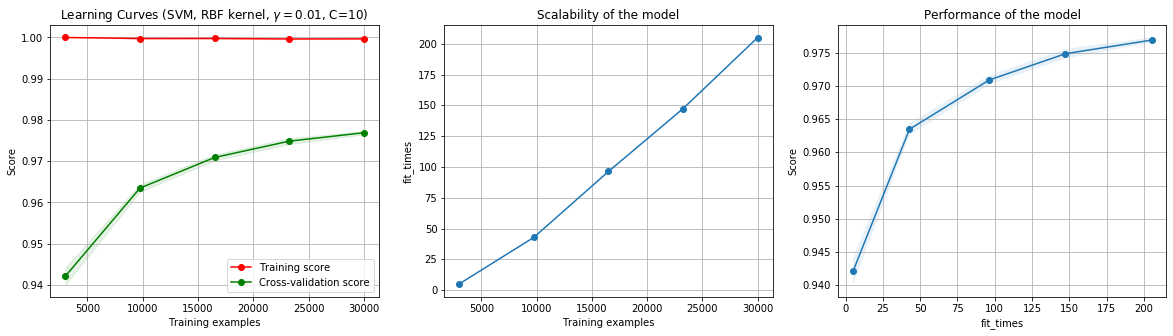

In [10]:
# specify range of hyperparameters
# Set the parameters by cross-validation

# hyper_params = [{'kernel': ['rbf'],'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
hyper_params = [{'kernel': ['rbf'],'gamma': [1e-2], 'C': [10]}]

scores = ['accuracy']
folds = 5

# specify model
model = SVC()

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= score, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1)
    
    model_cv.fit(train_images, train_labels_raw)

    print("Best parameters set found on development set:")
    print()
    print(model_cv.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = model_cv.cv_results_['mean_test_score']
    stds = model_cv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model_cv.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    
    y_true, y_pred_svm = test_labels_raw, model_cv.predict(test_images)
    
    cm = confusion_matrix(y_true, y_pred_svm)
    
    metrics = counts_from_confusion(cm)
    display(metrics)
    
print()
make_confusion_matrix(cm, sum_stats='True',xyplotlabels= 'True',figsize=(8,6), cbar=True, cmap='Blues')

print()
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.01$, C=10)"

estimator = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
plot_learning_curve(estimator, title, train_images, train_labels_raw, cv=2, n_jobs=-1)

plt.show()

### 3.2 Naive Bayes

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



,Class,TP,FN,FP,TN,Accuracy,Sensitivity,Specificity,Support
0,0,870,231,110,8789,0.9659,0.790191,0.987639,980
1,1,1079,197,56,8668,0.9747,0.845611,0.993581,1135
2,2,266,28,766,8940,0.9206,0.904762,0.92108,1032
3,3,353,145,657,8845,0.9198,0.708835,0.930857,1010
4,4,168,22,814,8996,0.9164,0.884211,0.917023,982
5,5,44,36,848,9072,0.9116,0.55,0.914516,892
6,6,895,482,63,8560,0.9455,0.649964,0.992694,958
7,7,280,39,748,8933,0.9213,0.877743,0.922735,1028
8,8,648,1632,326,7394,0.8042,0.284211,0.957772,974
9,9,955,1630,54,7361,0.8316,0.369439,0.992717,1009


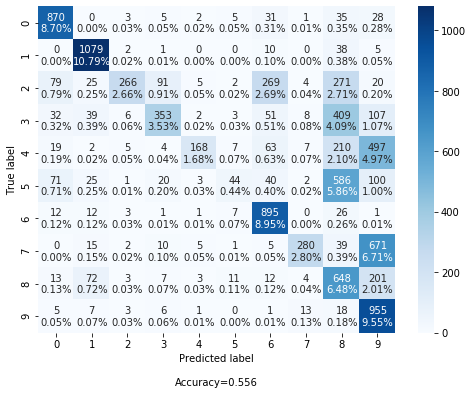

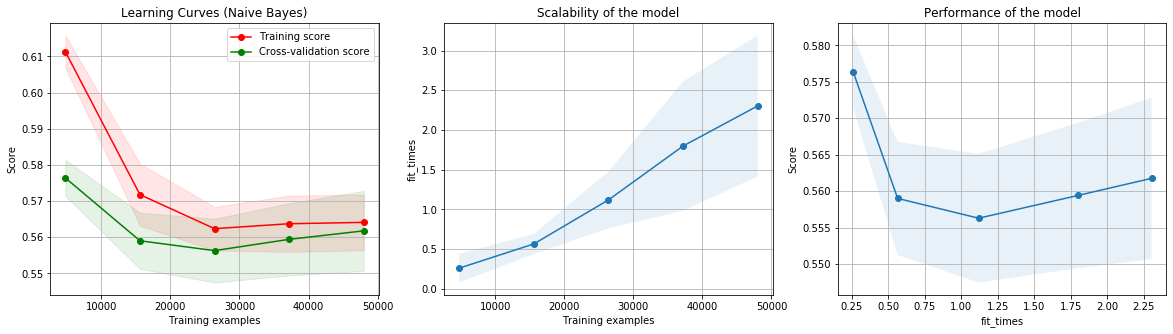

In [11]:
# specify range of hyperparameters
# Set the parameters by cross-validation

# specify model
gnb = GaussianNB()

model_gnb = gnb.fit(train_images, train_labels_raw)

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
    
y_true, y_pred_nb = test_labels_raw, model_gnb.predict(test_images)
    
cm = confusion_matrix(y_true, y_pred_nb)
    
metrics = counts_from_confusion(cm)
display(metrics)

print()
make_confusion_matrix(cm, sum_stats='True',xyplotlabels= 'True',figsize=(8,6), cbar=True, cmap='Blues')

print()
title = r"Learning Curves (Naive Bayes)"

estimator = GaussianNB()
plot_learning_curve(estimator, title, train_images, train_labels_raw, cv=5, n_jobs=-1)

plt.show()

### 3.3 Convolution Neural Net

### 3.3.1 Pre-Processing

#### Preparing Image Data

In [12]:
train_images = train_images_raw.reshape((train_images_raw.shape[0], train_images_raw.shape[1], train_images_raw.shape[2], 1))
train_images = train_images.astype('float32')/255

test_images = test_images_raw.reshape((test_images_raw.shape[0], test_images_raw.shape[1], test_images_raw.shape[2], 1))
test_images = test_images.astype('float32')/255


print('Original image data:')
print(train_images_raw[0])
print()
print('Pre-processed image data:')
print(train_images[0])

Original image data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 2

#### Prepering Label Data

In [13]:
train_labels = to_categorical(train_labels_raw)
test_labels = to_categorical(test_labels_raw)

print('Original Label:')
print(train_labels_raw)
print()
print('One Hot Encoding:')
print(train_labels)


Original Label:
[5 0 4 ... 5 6 8]

One Hot Encoding:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [14]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D (32,(3,3), activation ='relu', input_shape = (28,28,1)))
model_cnn.add(layers.MaxPooling2D(2,2))
model_cnn.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation = 'relu'))
model_cnn.add(layers.Dense(10, activation = 'softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

Epoch 1/10
629/629 [==============================] - 12s 19ms/step - loss: 0.2162 - accuracy: 0.9321 - val_loss: 0.1158 - val_accuracy: 0.9631
Epoch 2/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.0702 - val_accuracy: 0.9798
Epoch 3/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.0512 - val_accuracy: 0.9866
Epoch 4/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0484 - val_accuracy: 0.9872
Epoch 5/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0543 - val_accuracy: 0.9867
Epoch 6/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0423 - val_accuracy: 0.9884
Epoch 7/10
629/629 [==============================] - 12s 19ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 0.0621 - val_accuracy:

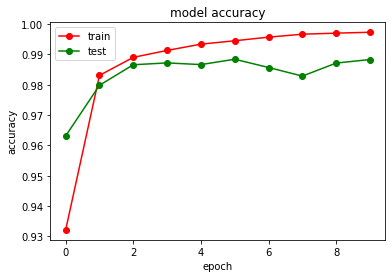

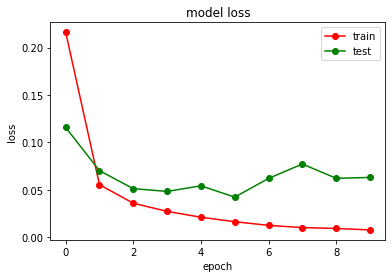

In [15]:
model_cnn.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model_cnn.fit(train_images, train_labels, validation_split=0.33, epochs = 10, batch_size = 64, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'],'o-', color="r")
plt.plot(history.history['val_accuracy'],'o-', color="g")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],'o-', color="r")
plt.plot(history.history['val_loss'],'o-', color="g")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'best')
plt.show()

,Class,TP,FN,FP,TN,Accuracy,Sensitivity,Specificity,Support
0,0,974,3,6,9017,0.9991,0.996929,0.999335,980
1,1,1126,4,9,8861,0.9987,0.99646,0.998985,1135
2,2,1027,9,5,8959,0.9986,0.991313,0.999442,1032
3,3,1005,12,5,8978,0.9983,0.988201,0.999443,1010
4,4,974,5,8,9013,0.9987,0.994893,0.999113,982
5,5,887,20,5,9088,0.9975,0.977949,0.99945,892
6,6,941,2,17,9040,0.9981,0.997879,0.998123,958
7,7,1020,12,8,8960,0.998,0.988372,0.999108,1028
8,8,962,9,12,9017,0.9979,0.990731,0.998671,974
9,9,996,12,13,8979,0.9975,0.988095,0.998554,1009


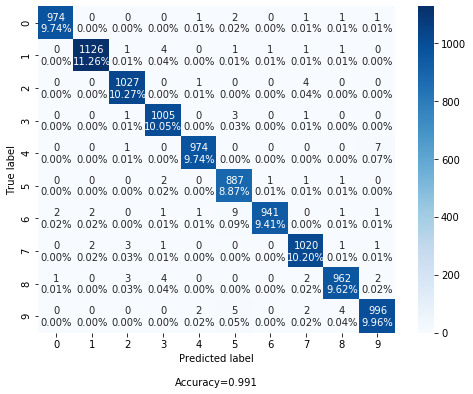

In [50]:

y_true, y_pred_cnn = test_labels, model_cnn.predict(test_images)

cm = confusion_matrix(y_true.argmax(axis=1), y_pred_cnn.argmax(axis=1))
    
metrics = counts_from_confusion(cm)
display(metrics)
  
print()
make_confusion_matrix(cm, sum_stats='True',xyplotlabels= 'True',figsize=(8,6),percent = True, cbar=True, cmap='Blues')
print()


## Comparing Models

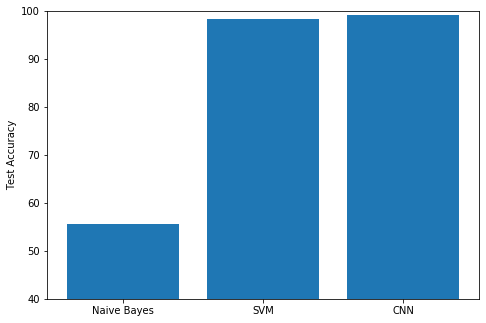

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Naive Bayes', 'SVM', 'CNN']
performance = [55.58,98.33,99.09]
ax.bar(langs,performance)
plt.ylim((40,100))
plt.ylabel('Test Accuracy')
plt.show()

### Incorrect Images

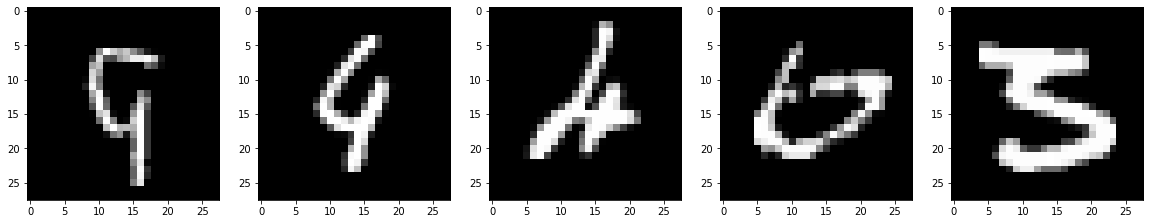

In [48]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(np.argmax(y_true, axis=1, out=None),np.argmax(y_pred_cnn, axis=1, out=None)):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(test_images[badIndex], (28,28)), cmap=plt.cm.gray)

### Saving Models

In [37]:
import pickle
#filename = 
pickle.dump(model_gnb, open(r'C:\Users\mnbas\Documents\MASc Courses\CP8305 - Knowledge Discovery\Project\Code\Models\NB_trained_model.sav', 'wb'))
pickle.dump(model_cv, open(r'C:\Users\mnbas\Documents\MASc Courses\CP8305 - Knowledge Discovery\Project\Code\Models\SVM_trained_model.sav', 'wb'))
pickle.dump(model_cnn, open(r'C:\Users\mnbas\Documents\MASc Courses\CP8305 - Knowledge Discovery\Project\Code\Models\CNN_trained_model.sav', 'wb'))

TypeError: can't pickle _thread.RLock objects